In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

#read the data from one directory up from script location

script_dir = os.path.dirname(os.getcwd())
#go to data directory
tilt_data_path = os.path.join(script_dir,  'CurrentPositionMapping', 'data', 'tilt_filtered_data.csv')

pan_data_path = os.path.join(script_dir,  'CurrentPositionMapping', 'data', 'pan_filtered_data.csv')
tilt_data = pd.read_csv(tilt_data_path)
pan_data = pd.read_csv(pan_data_path)
tilt_data = tilt_data.dropna()
pan_data = pan_data.dropna()

predictors = tilt_data.columns.drop(['TiltCurrent','PanCurrent', 'UniqueID'])
#Split the data into a training set and a testing set for tilt

x_train_tilt, x_test_tilt, y_train_tilt, y_test_tilt = train_test_split(tilt_data[predictors], tilt_data['TiltCurrent'], test_size=0.2, random_state=42)
x_train_pan, x_test_pan, y_train_pan, y_test_pan = train_test_split(pan_data[predictors], pan_data['PanCurrent'], test_size=0.2, random_state=42)

In [34]:
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
import json
import sys
from keras.optimizers import Adam


def create_model_with_weights(weights_path, model_name):
    # Try to load model from config file
    config_path = weights_path.replace('.weights.h5', '_config.json')
    if os.path.exists(config_path):
        try:
            with open(config_path, 'r') as f:
                config = json.load(f)
            
            model = Sequential()
            model.name = model_name
            
            # First layer needs input shape
            model.add(Input(shape=(10,)))  
            
            for layer in config['layers']:
                if layer['class_name'] == 'Dense':
                    layer_config = layer['config']
                    regularizer = None
                    if layer_config.get('kernel_regularizer'):
                        reg_config = layer_config['kernel_regularizer']['config']
                        regularizer = l2(reg_config.get('l2', 0))
                    
                    model.add(Dense(
                        units=layer_config['units'],
                        activation=layer_config['activation'],
                        kernel_regularizer=regularizer
                    ))
                elif layer['class_name'] == 'BatchNormalization':
                    model.add(BatchNormalization())
                elif layer['class_name'] == 'Dropout':
                    model.add(Dropout(layer['config']['rate']))
            
            # Compile model
            model.compile(optimizer=Adam(learning_rate=0.001), 
                          loss='mean_squared_error', 
                          metrics=['mae'])
            
            # Load pretrained weights
            model.load_weights(weights_path)
            
            print(f"Successfully loaded model from config: {config_path}", file=sys.stderr)
            return model
            
        except Exception as e:
            print(f"Error loading model from config: {e}", file=sys.stderr)
            print("Falling back to default model architecture", file=sys.stderr)
    
    # Fallback to default implementation
    print(f"Using default model architecture for {model_name}", file=sys.stderr)
    model = Sequential()
    model.name = model_name
    model.add(Input(shape=(10,)))  # Changed from 11 to 10 to match actual input size
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    model.load_weights(weights_path)
    return model


In [35]:
tilt_model = create_model_with_weights('weights/tilt_filtered_model.weights.h5', 'tilt_model')
pan_model = create_model_with_weights('weights/pan_filtered_model.weights.h5', 'pan_model')

/Users/pierre/ikaros/Source/Modules/RobotModules/CompliantRobot/TestMapping/.tensorflow_venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
Successfully loaded model from config: weights/tilt_filtered_model_config.json
Successfully loaded model from config: weights/pan_filtered_model_config.json


In [41]:
#plot predictions of tilit current given current tilit position and tiltdistance to target
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(y_true_list, x_test_list, y_test_list, title='Predictions vs True', xlabel='True', ylabel='Predicted', figsize=(8, 8), models=None, means_std_list=None):
    if models is not None:
        # Plot multiple models as subplots
        fig, axes = plt.subplots(1, len(models), figsize=(8 * len(models), 8))
        if len(models) == 1:
            axes = [axes]
        
        for i, model in enumerate(models):
            # Use the corresponding data for each model
            current_x_test = x_test_list[i]
            current_y_test = y_test_list[i]
            current_y_true = y_true_list[i]
            
            # Make predictions
            y_pred = model.predict(current_x_test).flatten()
            
            #Denormalize the data
            y_pred = y_pred * means_std_list[i][1] + means_std_list[i][0]
            current_y_true = current_y_true * means_std_list[i][1] + means_std_list[i][0]
            


            # Plot
            axes[i].scatter(current_y_true, y_pred, alpha=0.5, label=model.name)
            axes[i].plot([current_y_true.min(), current_y_true.max()], 
                         [current_y_true.min(), current_y_true.max()], 'k--', lw=2)
            axes[i].set_xlabel(xlabel)
            axes[i].set_ylabel(ylabel)
            axes[i].set_title(f"{title} - {model.name} (MSE: {model.evaluate(current_x_test, current_y_test, verbose=0)[0]:.4f})")
            axes[i].legend()
        
        plt.tight_layout()
    else:
        print("No models provided to plot.")






547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


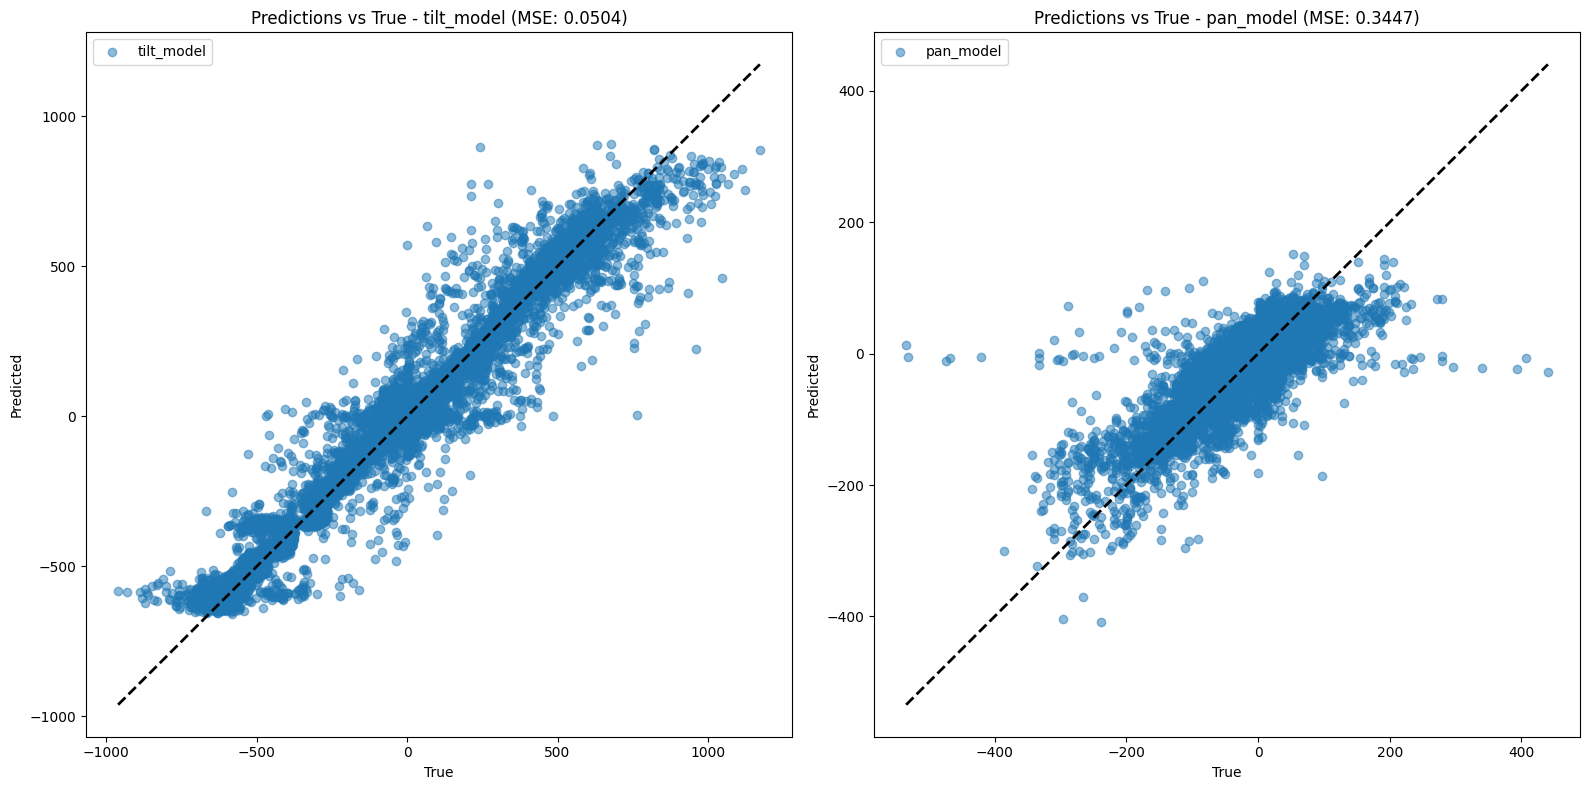

In [42]:
# Read the tilt_mean_std.json file to get the mean and std values
import json

with open('weights/tilt_mean_std.json', 'r') as f:
    tilt_data = json.load(f)
    
# Extract the mean and std for TiltCurrent
tilt_means_std = (tilt_data['TiltCurrent']['mean'], tilt_data['TiltCurrent']['std'])

with open('weights/pan_mean_std.json', 'r') as f:
    pan_data = json.load(f)

# Extract the mean and std for PanCurrent
pan_means_std = (pan_data['PanCurrent']['mean'], pan_data['PanCurrent']['std'])



plot_predictions([y_test_tilt, y_test_pan],[x_test_tilt, x_test_pan], [y_test_tilt, y_test_pan], models=[tilt_model, pan_model], means_std_list=[tilt_means_std, pan_means_std])



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


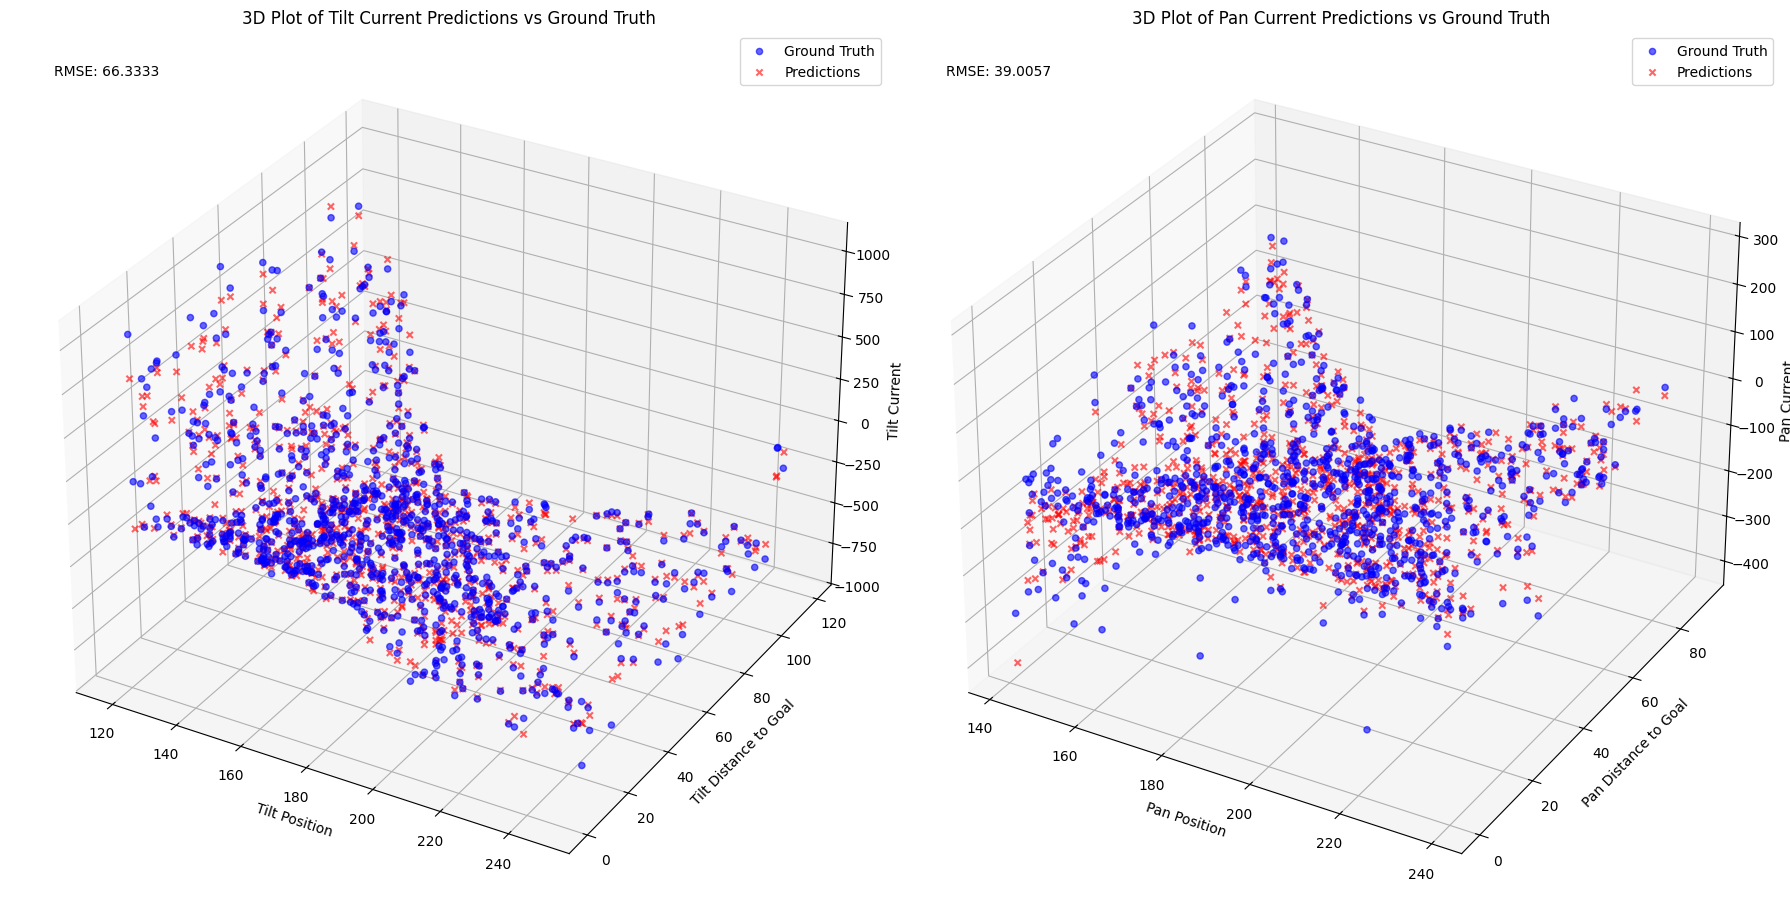

In [65]:
# Create 3D plots to visualize predictions vs ground truth for both tilt and pan
# in relationship to position and distance to goal

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to create 3D plots
def plot_3d_predictions(models, x_test_list, y_test_list, means_std_list, feature_indices=(0, 1)):
    """
    Create 3D plots showing predictions vs ground truth based on position and distance to goal
    
    Parameters:
    - models: List of trained models [tilt_model, pan_model]
    - x_test_list: List of test input data for each model
    - y_test_list: List of test output data for each model
    - means_std_list: List of (mean, std) tuples for denormalization
    - feature_indices: Tuple of indices for the two features to plot (default: position and distance)
    """
    if not models or len(models) != len(x_test_list) or len(models) != len(y_test_list):
        print("Error: Models and test data lists must have the same length")
        return
    
    fig = plt.figure(figsize=(18, 10))
    titles = ['Tilt', 'Pan']
    sample_size = 1000
    
    for i, (model, x_test, y_test, means_std) in enumerate(zip(models, x_test_list, y_test_list, means_std_list)):
        # Take sample_size rows from x_test
        x_test_samples = x_test.iloc[:sample_size]
        y_test_samples = y_test.iloc[:sample_size].values  # Convert to numpy array
        
        # Make predictions
        y_pred = model.predict(x_test_samples).flatten()  # Flatten to ensure 1D array
        
        # Denormalize predictions and ground truth
        current_key = 'TiltCurrent' if i == 0 else 'PanCurrent'
        y_pred_denorm = y_pred * means_std[current_key]['std'] + means_std[current_key]['mean']
        y_test_denorm = y_test_samples * means_std[current_key]['std'] + means_std[current_key]['mean']
        
        # Extract the two features for plotting
        position = x_test_samples[f'{titles[i]}Pos'].values  # Convert to numpy array
        distance_to_goal = x_test_samples[f'{titles[i]}DistToGoal'].values  # Convert to numpy arraya
        
        position = position * means_std[f'{titles[i]}Position']['std'] + means_std[f'{titles[i]}Position']['mean']
        distance_to_goal = distance_to_goal * means_std[f'{titles[i]}DistToGoal']['std'] + means_std[f'{titles[i]}DistToGoal']['mean']
        # Create 3D subplot
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        
        # Plot ground truth
        ax.scatter(position, distance_to_goal, y_test_denorm, c='blue', marker='o', alpha=0.6, label='Ground Truth')
        
        # Plot predictions
        ax.scatter(position, distance_to_goal, y_pred_denorm, c='red', marker='x', alpha=0.6, label='Predictions')
        
        # Set labels and title
        ax.set_xlabel(f'{titles[i]} Position')
        ax.set_ylabel(f'{titles[i]} Distance to Goal')
        ax.set_zlabel(f'{titles[i]} Current')
        ax.set_title(f'3D Plot of {titles[i]} Current Predictions vs Ground Truth')
        
        # Add legend
        ax.legend()
        
        # Calculate and display RMSE
        rmse = np.sqrt(np.mean((y_pred_denorm - y_test_denorm)**2))
        ax.text2D(0.05, 0.95, f'RMSE: {rmse:.4f}', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()


#retreive mean and std from tilt_mean_std.json and pan_mean_std.json
with open('weights/tilt_mean_std.json', 'r') as f:
    tilt_mean_std = json.load(f)

with open('weights/pan_mean_std.json', 'r') as f:
    pan_mean_std = json.load(f)

# Call the function with our models and data
# Assuming the first two features (indices 0 and 1) are position and distance to goal
plot_3d_predictions(
    models=[tilt_model, pan_model],
    x_test_list=[x_test_tilt, x_test_pan],
    y_test_list=[y_test_tilt, y_test_pan],
    means_std_list=[tilt_mean_std, pan_mean_std],
    feature_indices=(0, 1)  # Adjust these indices if position and distance are at different positions
)


In [68]:
# Create a function to plot topographical maps of prediction errors
def plot_error_maps(models, x_test_list, y_test_list, means_std_list, feature_indices=(0, 1)):
    titles = ['Tilt', 'Pan']
    fig = plt.figure(figsize=(18, 6))
    sample_size = 1000
    
    for i, (model, x_test, y_test, means_std) in enumerate(zip(models, x_test_list, y_test_list, means_std_list)):
        
        #take 50 rows from x_test
        x_test_samples = x_test.iloc[:sample_size]
        y_test_samples = y_test.iloc[:sample_size].values  # Convert to numpy array

        # Get predictions
        y_pred = model.predict(x_test_samples)
        
        # Denormalize predictions and ground truth
        y_pred_denorm = y_pred * means_std[f'{titles[i]}Current']['std'] + means_std[f'{titles[i]}Current']['mean']
        y_test_denorm = y_test_samples * means_std[f'{titles[i]}Current']['std'] + means_std[f'{titles[i]}Current']['mean']
        
        # Calculate absolute errors
        errors = np.abs(y_pred_denorm - y_test_denorm)
        
        # Extract position and distance features
        position = x_test[:, feature_indices[0]]
        distance_to_goal = x_test[:, feature_indices[1]]
        
        # Denormalize features
        position = position * means_std[f'{titles[i]}Position']['std'] + means_std[f'{titles[i]}Position']['mean']
        distance_to_goal = distance_to_goal * means_std[f'{titles[i]}DistToGoal']['std'] + means_std[f'{titles[i]}DistToGoal']['mean']
        
        # Create a grid for the contour plot
        pos_min, pos_max = position.min(), position.max()
        dist_min, dist_max = distance_to_goal.min(), distance_to_goal.max()
        
        pos_grid = np.linspace(pos_min, pos_max, 100)
        dist_grid = np.linspace(dist_min, dist_max, 100)
        
        pos_mesh, dist_mesh = np.meshgrid(pos_grid, dist_grid)
        
        # Create subplot
        ax = fig.add_subplot(1, 3, i+1)
        
        # Use griddata to interpolate scattered data to a regular grid
        error_grid = griddata(
            (position.flatten(), distance_to_goal.flatten()), 
            errors.flatten(), 
            (pos_mesh, dist_mesh), 
            method='cubic', 
            fill_value=0
        )
        
        # Create contour plot
        contour = ax.contourf(pos_mesh, dist_mesh, error_grid, cmap='viridis', levels=20)
        
        # Add colorbar
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label('Absolute Error')
        
        # Set labels and title
        ax.set_xlabel(f'{titles[i]} Position')
        ax.set_ylabel(f'{titles[i]} Distance to Goal')
        ax.set_title(f'Error Map for {titles[i]} Current Predictions')
        
        # Calculate and display RMSE
        rmse = np.sqrt(np.mean(errors**2))
        ax.text(0.05, 0.95, f'RMSE: {rmse:.4f}', transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Add a combined error map as the third plot
    ax = fig.add_subplot(1, 3, 3)
    
    # Combine errors from both models (assuming they have the same dimensions)
    combined_position = np.concatenate([
        x_test_list[0][:, feature_indices[0]] * means_std_list[0][f'{titles[0]}Position']['std'] + means_std_list[0][f'{titles[0]}Position']['mean'],
        x_test_list[1][:, feature_indices[0]] * means_std_list[1][f'{titles[1]}Position']['std'] + means_std_list[1][f'{titles[1]}Position']['mean']
    ])
    
    combined_distance = np.concatenate([
        x_test_list[0][:, feature_indices[1]] * means_std_list[0][f'{titles[0]}DistToGoal']['std'] + means_std_list[0][f'{titles[0]}DistToGoal']['mean'],
        x_test_list[1][:, feature_indices[1]] * means_std_list[1][f'{titles[1]}DistToGoal']['std'] + means_std_list[1][f'{titles[1]}DistToGoal']['mean']
    ])
    
    # Calculate predictions and errors for both models
    y_pred_tilt = models[0].predict(x_test_list[0])
    y_pred_pan = models[1].predict(x_test_list[1])
    
    # Denormalize
    y_pred_tilt_denorm = y_pred_tilt * means_std_list[0][f'{titles[0]}Current']['std'] + means_std_list[0][f'{titles[0]}Current']['mean']
    y_test_tilt_denorm = y_test_list[0] * means_std_list[0][f'{titles[0]}Current']['std'] + means_std_list[0][f'{titles[0]}Current']['mean']
    
    y_pred_pan_denorm = y_pred_pan * means_std_list[1][f'{titles[1]}Current']['std'] + means_std_list[1][f'{titles[1]}Current']['mean']
    y_test_pan_denorm = y_test_list[1] * means_std_list[1][f'{titles[1]}Current']['std'] + means_std_list[1][f'{titles[1]}Current']['mean']
    
    # Calculate errors
    errors_tilt = np.abs(y_pred_tilt_denorm - y_test_tilt_denorm)
    errors_pan = np.abs(y_pred_pan_denorm - y_test_pan_denorm)
    
    # Combine errors
    combined_errors = np.concatenate([errors_tilt, errors_pan])
    
    # Create a grid for the combined contour plot
    pos_min, pos_max = combined_position.min(), combined_position.max()
    dist_min, dist_max = combined_distance.min(), combined_distance.max()
    
    pos_grid = np.linspace(pos_min, pos_max, 100)
    dist_grid = np.linspace(dist_min, dist_max, 100)
    
    pos_mesh, dist_mesh = np.meshgrid(pos_grid, dist_grid)
    
    # Interpolate combined errors
    combined_error_grid = griddata(
        (combined_position.flatten(), combined_distance.flatten()), 
        combined_errors.flatten(), 
        (pos_mesh, dist_mesh), 
        method='cubic', 
        fill_value=0
    )
    
    # Create contour plot for combined errors
    contour = ax.contourf(pos_mesh, dist_mesh, combined_error_grid, cmap='viridis', levels=20)
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Absolute Error')
    
    # Set labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Distance to Goal')
    ax.set_title('Combined Error Map')
    
    # Calculate and display combined RMSE
    combined_rmse = np.sqrt(np.mean(combined_errors**2))
    ax.text(0.05, 0.95, f'RMSE: {combined_rmse:.4f}', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Import necessary libraries for interpolation
from scipy.interpolate import griddata

# Call the function with our models and data
plot_error_maps(
    models=[tilt_model, pan_model],
    x_test_list=[x_test_tilt, x_test_pan],
    y_test_list=[y_test_tilt, y_test_pan],
    means_std_list=[tilt_mean_std, pan_mean_std],
    feature_indices=(0, 1)  # Adjust these indices if position and distance are at different positions
)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1800x600 with 0 Axes>

In [ ]:
raw_data = pd.read_csv('data/Tra.csv')

In [15]:
#make a prediction for a given tilt position and tilt distance to target, and gyro and accel data
best_model.predict(np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[0.02088113]], dtype=float32)

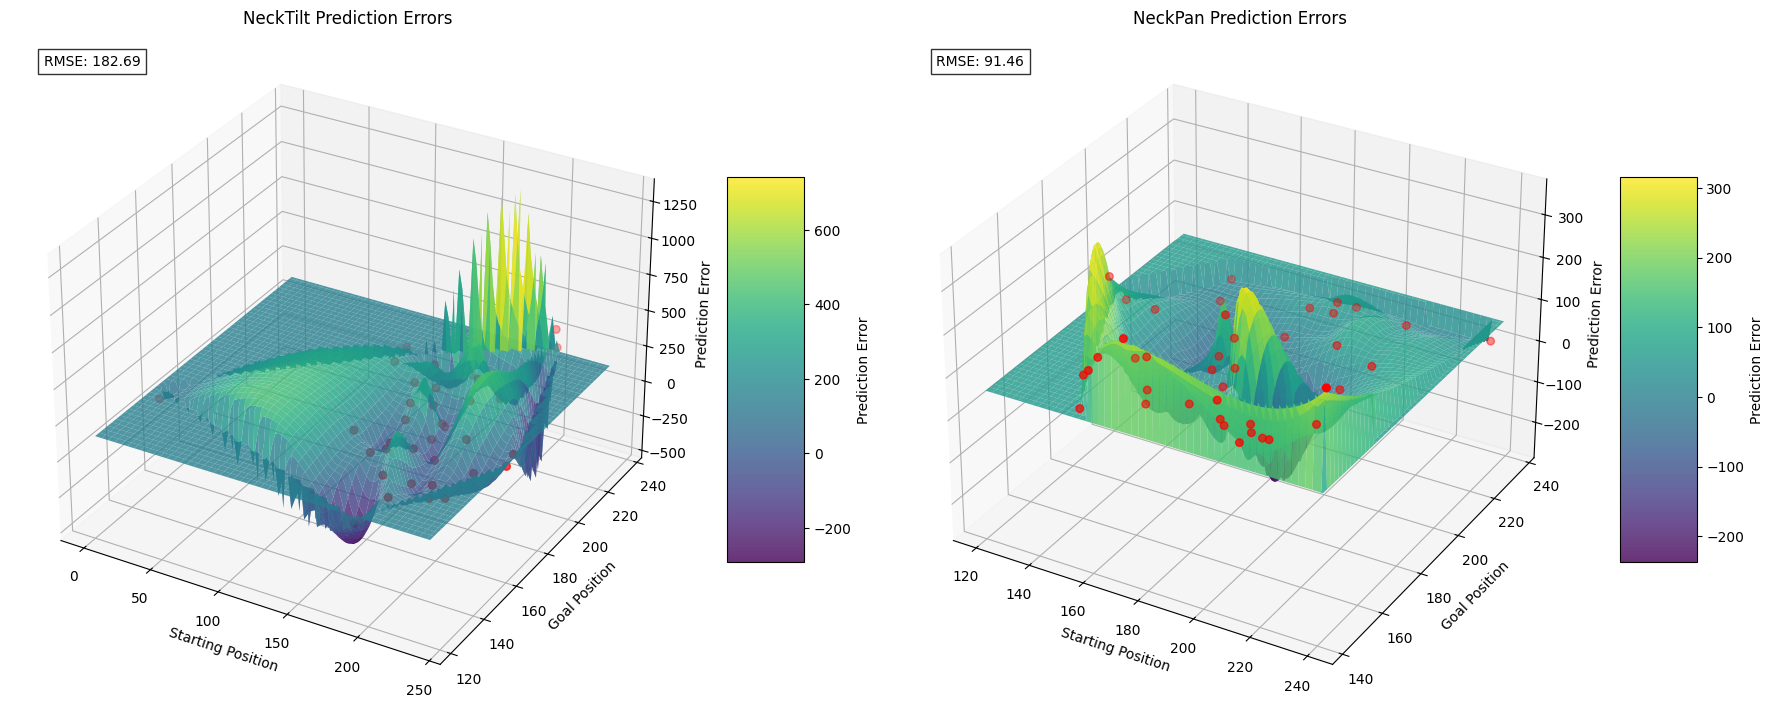

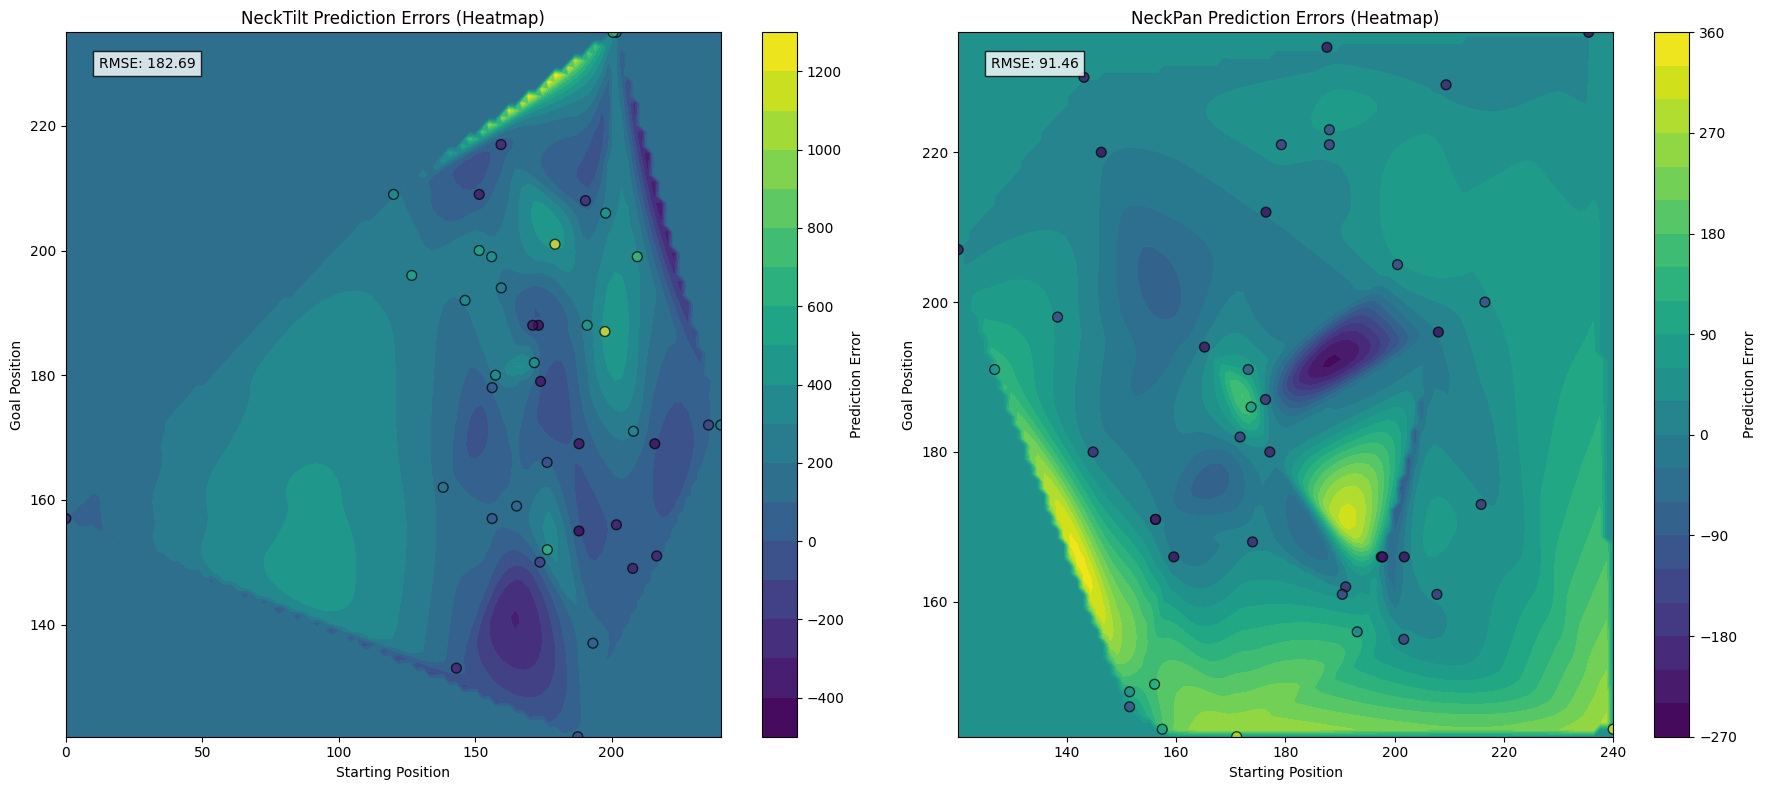

In [1]:
# Load the JSON data from the ANN results file
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata

# Load the data from the ANN results file
with open('results/ANN/current_data_260325.json', 'r') as f:
    data = json.load(f)

# Extract the data for both servos
transitions = data['transitions'][0]
tilt_data = transitions['NeckTilt']
pan_data = transitions['NeckPan']

# Create a figure with two subplots for Tilt and Pan
fig = plt.figure(figsize=(18, 8))

# Function to create 3D topological map for a servo
def plot_3d_error_map(ax, servo_data, title):
    start_pos = np.array(servo_data['starting_positions'])
    goal_pos = np.array(servo_data['goal_positions'])
    errors = np.array(servo_data['prediction_errors'])
    
    # Create a meshgrid for interpolation
    xi = np.linspace(min(start_pos), max(start_pos), 100)
    yi = np.linspace(min(goal_pos), max(goal_pos), 100)
    X, Y = np.meshgrid(xi, yi)
    
    # Interpolate the errors onto the meshgrid
    Z = griddata((start_pos, goal_pos), errors, (X, Y), method='cubic', fill_value=np.mean(errors))
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.8)
    
    # Plot the original data points
    ax.scatter(start_pos, goal_pos, errors, c='red', marker='o', s=30, label='Data points')
    
    # Set labels and title
    ax.set_xlabel('Starting Position')
    ax.set_ylabel('Goal Position')
    ax.set_zlabel('Prediction Error')
    ax.set_title(title)
    
    # Add colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Prediction Error')
    
    # Calculate and display RMSE
    rmse = np.sqrt(np.mean(errors**2))
    ax.text2D(0.05, 0.95, f'RMSE: {rmse:.2f}', transform=ax.transAxes,
              bbox=dict(facecolor='white', alpha=0.8))

# Create the subplots
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot the data
plot_3d_error_map(ax1, tilt_data, 'NeckTilt Prediction Errors')
plot_3d_error_map(ax2, pan_data, 'NeckPan Prediction Errors')

plt.tight_layout()
plt.show()

# Also create a 2D heatmap view for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

def plot_2d_heatmap(ax, servo_data, title):
    start_pos = np.array(servo_data['starting_positions'])
    goal_pos = np.array(servo_data['goal_positions'])
    errors = np.array(servo_data['prediction_errors'])
    
    # Create a meshgrid for interpolation
    xi = np.linspace(min(start_pos), max(start_pos), 100)
    yi = np.linspace(min(goal_pos), max(goal_pos), 100)
    X, Y = np.meshgrid(xi, yi)
    
    # Interpolate the errors onto the meshgrid
    Z = griddata((start_pos, goal_pos), errors, (X, Y), method='cubic', fill_value=np.mean(errors))
    
    # Plot the heatmap
    im = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    
    # Plot the original data points
    scatter = ax.scatter(start_pos, goal_pos, c=errors, cmap='viridis', 
                         edgecolors='k', s=50, alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel('Starting Position')
    ax.set_ylabel('Goal Position')
    ax.set_title(title)
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Prediction Error')
    
    # Calculate and display RMSE
    rmse = np.sqrt(np.mean(errors**2))
    ax.text(0.05, 0.95, f'RMSE: {rmse:.2f}', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

# Plot the 2D heatmaps
plot_2d_heatmap(ax1, tilt_data, 'NeckTilt Prediction Errors (Heatmap)')
plot_2d_heatmap(ax2, pan_data, 'NeckPan Prediction Errors (Heatmap)')

plt.tight_layout()
plt.show()
